In [2]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES|"]="1"



# 출처: https://dongjinlee.tistory.com/entry/선택한-GPU에만-메모리-할당하는-방법 [다함께 차차차]

Using TensorFlow backend.


In [3]:
data = pd.read_csv('../SHAP/Allmerge2.csv', index_col='acc_id')
data= data.drop(columns='Unnamed: 0')
test = pd.read_csv('../SHAP/Allmerge_test_notinlabel.csv', index_col='acc_id')
df = pd.concat([data, test])

In [4]:
data.head()

,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,playtime,...,pledge_combat_cnt,random_attacker_cnt_plg,random_defender_cnt_plg,same_pledge_cnt_plg,temp_cnt_plg,etc_cnt_plg,combat_play_time,non_combat_play_time,survival_time,amount_spent
acc_id,,,,,,,,,,,,,,,,,,,,,
2,28,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.685947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64,0.000000
5,36,173,0.000000,0.000000,0.000000,0.479728,0.000000,0.000000,0.098129,6.193126,...,0.000000,1.936569,0.929907,0.000000,2.570959,0.814001,5.097608,0.004402,60,0.000000
8,485,1922,0.128368,4.270875,1.183064,3.837822,0.000000,0.900892,3.041991,19.034441,...,2.717332,33.631748,21.745527,29.441536,92.455650,61.354404,136.879854,0.033823,64,0.020310
17,34,687,0.000000,0.000000,2.366129,3.358094,12.398273,0.675669,1.373803,28.823040,...,0.486279,9.230979,10.872764,1.591434,36.784494,12.514373,65.693573,0.000000,64,0.070642
20,158,624,1.283685,0.000000,1.183064,0.479728,0.000000,16.441283,10.107262,25.910161,...,7.964404,11.974452,6.580883,11.140041,28.379435,44.409036,66.451919,0.000000,64,0.052137


In [5]:
test.head()

,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,playtime,...,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt_plg,random_defender_cnt_plg,same_pledge_cnt_plg,temp_cnt_plg,etc_cnt_plg,combat_play_time,non_combat_play_time
acc_id,,,,,,,,,,,,,,,,,,,,,
7,27,112,0.0,0.000000,0.000000,1.918911,0.0,0.000000,0.294386,1.268015,...,19.560411,7.614846,0.506312,19.527071,4.721068,0.000000,12.558147,4.098316,12.579598,0.000000
15,273,1121,0.0,0.000000,39.041128,0.000000,0.0,2.027007,2.256961,86.784346,...,99.317807,15.410139,0.000000,0.000000,48.355185,0.000000,4.054205,1.797879,107.054983,16.478587
16,3,62,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.082954,...,1.190948,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.007078,0.074364,0.056062
18,13,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,40.512476,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,111,663,0.0,3.131975,9.464516,1.918911,0.0,2.815288,4.219536,85.198735,...,17.034159,2.526252,0.000000,0.710075,1.430627,1.591434,5.339685,0.481322,10.912210,2.733728


In [3]:
df.head()

,amount_spent,amount_spent_pmt,boss_monster,class,combat_char_cnt,combat_play_time,death,enchant_count,etc_cnt,etc_cnt_plg,...,random_attacker_cnt_plg,random_defender_cnt,random_defender_cnt_plg,revive,same_pledge_cnt,same_pledge_cnt_plg,solo_exp,survival_time,temp_cnt,temp_cnt_plg
acc_id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0,28,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.0,0.000000,0.000000
5,0.000000,0.000000,9,36,1.587930,5.097608,0.245370,0.0,0.000000,0.814001,...,1.936569,0.000000,0.929907,0.246819,0.000000,0.000000,2.151033,60.0,0.479728,2.570959
8,0.020310,1.404644,2,485,58.031626,136.879854,91.768298,0.0,0.900892,61.354404,...,33.631748,1.183064,21.745527,92.310423,0.000000,29.441536,31.424841,64.0,3.837822,92.455650
17,0.070642,0.000000,21,34,21.689681,65.693573,1.717588,0.0,0.675669,12.514373,...,9.230979,2.366129,10.872764,1.727735,12.398273,1.591434,9.236949,64.0,3.358094,36.784494
20,0.052137,0.896531,8,158,25.515149,66.451919,0.981479,0.0,16.441283,44.409036,...,11.974452,1.183064,6.580883,0.987277,0.000000,11.140041,0.274340,64.0,0.479728,28.379435


In [4]:
df.dtypes

amount_spent               float64
amount_spent_pmt           float64
boss_monster                 int64
class                        int64
combat_char_cnt            float64
combat_play_time           float64
death                      float64
enchant_count              float64
etc_cnt                    float64
etc_cnt_plg                float64
exp_recovery               float64
fishing                    float64
game_money_change          float64
level                        int64
non_combat_play_time       float64
npc_kill                   float64
num_opponent               float64
party_exp                  float64
play_char_cnt              float64
playtime                   float64
pledge_cnt                 float64
pledge_combat_cnt          float64
private_shop               float64
quest_exp                  float64
random_attacker_cnt        float64
random_attacker_cnt_plg    float64
random_defender_cnt        float64
random_defender_cnt_plg    float64
revive              

In [5]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in data.columns if col != 'amount_spent']
len(feats)

34

In [6]:
feats

['class',
 'level',
 'pledge_cnt',
 'random_attacker_cnt',
 'random_defender_cnt',
 'temp_cnt',
 'same_pledge_cnt',
 'etc_cnt',
 'num_opponent',
 'playtime',
 'npc_kill',
 'solo_exp',
 'party_exp',
 'quest_exp',
 'boss_monster',
 'death',
 'revive',
 'exp_recovery',
 'fishing',
 'private_shop',
 'game_money_change',
 'enchant_count',
 'amount_spent_pmt',
 'play_char_cnt',
 'combat_char_cnt',
 'pledge_combat_cnt',
 'random_attacker_cnt_plg',
 'random_defender_cnt_plg',
 'same_pledge_cnt_plg',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'combat_play_time',
 'non_combat_play_time',
 'survival_time']

In [7]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = data[feats]
y_data = data['amount_spent']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-373939071707.4183

In [8]:
%%time
basic_archive = rfe(x_data, y_data, 'basic')

34 -373939071707.4183
Wall time: 1.01 s


In [9]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['amount_spent']))

40 -373939071707.4183
45 -373939071707.4183
50 -373939071707.4183
55 -373939071707.4183
60 -373939071707.4183
65 -373939071707.4183
70 -373939071707.4183
75 -373939071707.4183
80 -373939071707.4183
85 -373939071707.4183


In [10]:
%%time
perm_archive = rfe(x_data, y_data, 'perm')

34 -373939071707.4183
Wall time: 5.75 s


In [11]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
0.6030 ± 0.1705,x22
0.3890 ± 0.0782,x33
0.0431 ± 0.0237,x20
0.0177 ± 0.0067,x9
0.0156 ± 0.0054,x1
0.0142 ± 0.0108,x0
0.0126 ± 0.0278,x11
0.0107 ± 0.0067,x27
0.0095 ± 0.0073,x25
0.0072 ± 0.0045,x31


In [12]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['amount_spent']))

40 -373939071707.4183
45 -373939071707.4183
50 -373939071707.4183
55 -373939071707.4183
60 -373939071707.4183
65 -373939071707.4183
70 -373939071707.4183
75 -373939071707.4183
80 -373939071707.4183
85 -373939071707.4183


In [13]:
%%time
shap_archive = rfe(x_data, y_data, 'shap')

34 -373939071707.4183
Wall time: 3.03 s


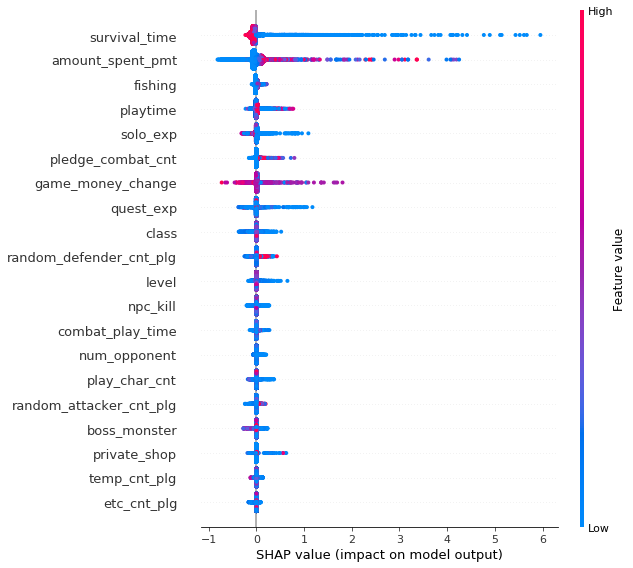

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [15]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['amount_spent']))

40 -373939071707.4183
45 -373939071707.4183
50 -373939071707.4183
55 -373939071707.4183
60 -373939071707.4183
65 -373939071707.4183
70 -373939071707.4183
75 -373939071707.4183
80 -373939071707.4183
85 -373939071707.4183


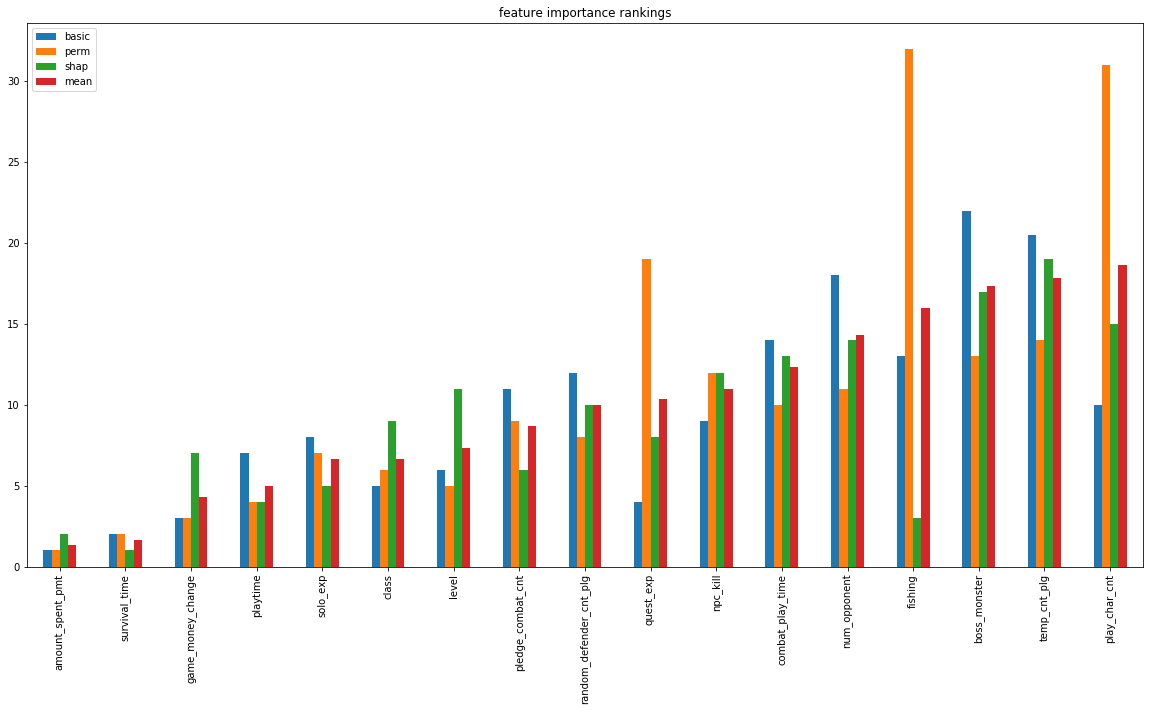

In [16]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [17]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['amount_spent']))

40 -373939071707.4183
45 -373939071707.4183
50 -373939071707.4183
55 -373939071707.4183
60 -373939071707.4183
65 -373939071707.4183
70 -373939071707.4183
75 -373939071707.4183
80 -373939071707.4183
85 -373939071707.4183


In [18]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['amount_spent'].values)

KeyboardInterrupt: 

In [19]:
evaluate(data[np.array(feats)[feat_selector.support_]], data['amount_spent'])

AttributeError: 'BorutaPy' object has no attribute 'support_'

In [ ]:

import numpy as np

import pandas as pd



import keras

import tensorflow as tf

from IPython.display import display

import PIL

 

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

In [ ]:
# gpu_test.py

import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

shape = (int(10000), int(10000))

# with tf.device("/cpu:0"):
with tf.device("/gpu:0"):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    result = session.run(sum_operation)
    print(result)

print("\n" * 2)
print("Time taken:", datetime.now() - startTime)
print("\n" * 2)